 **Loading the  packages**


In [24]:
library(modeltime)
library(tidymodels)
library(timetk)
library(dplyr)
library(lubridate)
library(ggplot2)
library(zoo)
library(modeltime.ensemble)
library(plotly)
library(ggplot2)

**Loading the data**

In [25]:
data <- tibble(
  date  = as.Date(as.yearmon(time(AirPassengers))),
  value = as.numeric(AirPassengers)
)

**Plotting the data**

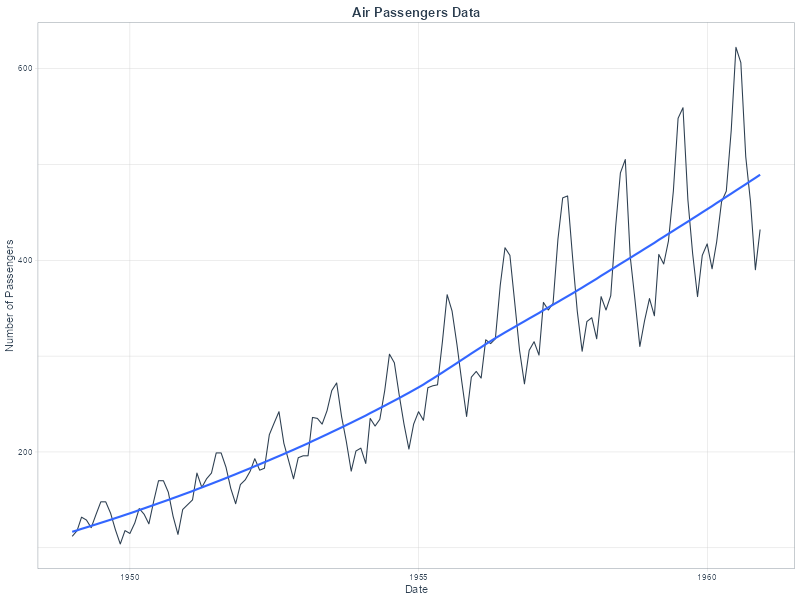

In [26]:
data %>% plot_time_series(date, value,.title="Air Passengers Data", 
.x_lab="Date", .y_lab="Number of Passengers",.interactive = F)+
  theme(plot.title=element_text(hjust=0.5,face="bold"))

In [28]:
features <- data %>%
  select(date, value) %>%
  tk_augment_timeseries_signature()

tk_augment_timeseries_signature(): Using the following .date_var variable: date


In [48]:
head(features)

# A tibble: 6 × 30
  date       value index.num    diff  year year.iso  half quarter month month.xts month.lbl   day  hour minute second hour12
  <date>     <dbl>     <dbl>   <dbl> <int>    <int> <int>   <int> <int>     <int> <ord>     <int> <int>  <int>  <int>  <int>
1 1949-01-01   112   -6.63e8      NA  1949     1948     1       1     1         0 January       1     0      0      0      0
2 1949-02-01   118   -6.60e8 2678400  1949     1949     1       1     2         1 February      1     0      0      0      0
3 1949-03-01   132   -6.58e8 2419200  1949     1949     1       1     3         2 March         1     0      0      0      0
4 1949-04-01   129   -6.55e8 2678400  1949     1949     1       2     4         3 April         1     0      0      0      0
5 1949-05-01   121   -6.52e8 2592000  1949     1949     1       2     5         4 May           1     0      0      0      0
6 1949-06-01   135   -6.50e8 2678400  1949     1949     1       2     6         5 June          1     0   

**Data Splitting**

In [30]:
splits <- initial_time_split(data, prop = 0.9)

**Model Defining for the Analysis**

In [32]:
model_arima <- arima_reg() %>%
  set_engine("auto_arima") %>%
  fit(value ~ date, data = training(splits))

model_ets <- exp_smoothing(seasonal_period = 12) %>%
  set_engine("ets") %>%
  fit(value ~ date, data = training(splits))

model_prophet <- prophet_reg() %>%
  set_engine("prophet") %>%
  fit(value ~ date, data = training(splits))

frequency = 12 observations per 1 year
Disabling weekly seasonality. Run prophet with weekly.seasonality=TRUE to override this.
Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.


Creating a model table 

In [33]:
models_tbl <- modeltime_table(
  model_arima,
  model_ets,
  model_prophet
)

Summary of each model on training data

In [34]:
# ARIMA Summary
models_tbl %>% 
  pluck_modeltime_model(1)

parsnip model object

Series: outcome 
ARIMA(1,1,0)(0,1,0)[12] 

Coefficients:
          ar1
      -0.2435
s.e.   0.0898

sigma^2 = 109.3:  log likelihood = -436.39
AIC=876.78   AICc=876.88   BIC=882.28

In [35]:
# ETS Summary
models_tbl %>% 
  pluck_modeltime_model(2)

parsnip model object

ETS(M,Ad,M) 

Call:
forecast::ets(y = outcome, model = model_ets, damped = damping_ets, 
    alpha = alpha, beta = beta, gamma = gamma)

  Smoothing parameters:
    alpha = 0.7699 
    beta  = 0.023 
    gamma = 1e-04 
    phi   = 0.9798 

  Initial states:
    l = 120.7418 
    b = 1.7557 
    s = 0.8969 0.7954 0.9171 1.0549 1.2142 1.2253
           1.1076 0.9793 0.982 1.0255 0.8933 0.9084

  sigma:  0.0382

     AIC     AICc      BIC 
1213.724 1219.943 1265.201 

In [36]:
# Prophet Model (no summary method, inspect structure)
models_tbl %>% 
  pluck_modeltime_model(3)

parsnip model object

PROPHET Model
- growth: 'linear'
- n.changepoints: 25
- changepoint.range: 0.8
- yearly.seasonality: 'auto'
- weekly.seasonality: 'auto'
- daily.seasonality: 'auto'
- seasonality.mode: 'additive'
- changepoint.prior.scale: 0.05
- seasonality.prior.scale: 10
- holidays.prior.scale: 10
- logistic_cap: NULL
- logistic_floor: NULL
- extra_regressors: 0

Defining Testing set 

In [37]:
calibration_tbl <- models_tbl %>%
  modeltime_calibrate(new_data = testing(splits))

Predicting the data for the test set 

In [38]:
calibration_tbl %>%
  modeltime_forecast(
    new_data = testing(splits),
    actual_data = data
  )

# Forecast Results
  Conf Method: conformal_default |
Conf Interval: 0.95 | Conf By ID:
FALSE (GLOBAL CONFIDENCE)
# A tibble: 189 × 7
   .model_id .model_desc .key  
       <int> <chr>       <fct> 
 1        NA ACTUAL      actual
 2        NA ACTUAL      actual
 3        NA ACTUAL      actual
 4        NA ACTUAL      actual
 5        NA ACTUAL      actual
 6        NA ACTUAL      actual
 7        NA ACTUAL      actual
 8        NA ACTUAL      actual
 9        NA ACTUAL      actual
10        NA ACTUAL      actual
# ℹ 179 more rows
# ℹ 4 more variables:
#   .index <date>, .value <dbl>,
#   .conf_lo <dbl>, .conf_hi <dbl>
# ℹ Use `print(n = ...)` to see more rows

Plotting the data for the test set 

Warning message:
In max(ids, na.rm = TRUE) : no non-missing arguments to max; returning -Inf


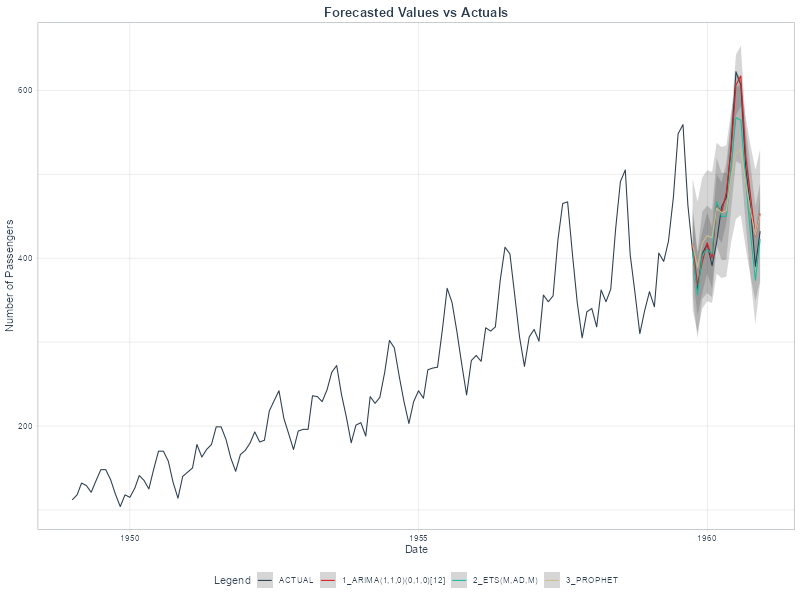

In [40]:
calibration_tbl %>%
  modeltime_forecast(
    new_data = testing(splits),
    actual_data = data
  ) %>%
  plot_modeltime_forecast(.title = "Forecasted Values vs Actuals",
                          .x_lab = "Date",
                          .y_lab = "Number of Passengers",
                          .interactive = F) +
  theme(plot.title = element_text(hjust = 0.5, face = "bold"))

# Model Evoluation 

In [72]:
calibration_tbl %>%
  modeltime_accuracy() %>%
  arrange(rmse)

# A tibble: 3 × 9
  .model_id .model_desc             .type   mae  mape  mase smape  rmse   rsq
      <int> <chr>                   <chr> <dbl> <dbl> <dbl> <dbl> <dbl> <dbl>
1         1 ARIMA(1,1,0)(0,1,0)[12] Test   14.0  3.18 0.310  3.10  18.1 0.957
2         2 ETS(M,AD,M)             Test   20.4  4.20 0.453  4.25  26.1 0.929
3         3 PROPHET                 Test   29.8  6.15 0.660  6.20  39.2 0.928

We Clearly see that ARIMA is the best model amoung the three model because the r square value for arima is 95.7%

Refitting the model for entire dataset

In [73]:
 # Refit for the entire dataset
refit_tbl <- calibration_tbl %>%
  modeltime_refit(data = data)

frequency = 12 observations per 1 year
Disabling weekly seasonality. Run prophet with weekly.seasonality=TRUE to override this.
Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.


Defining the prediction length (for forecasting)

In [74]:
# Forecasting for the next 12 months
future_tbl <- data %>%
  future_frame(.date_var = date, .length_out = 12)

Making forcast for every model in the modeltable

In [75]:
forecast_future <- refit_tbl %>%
  modeltime_forecast(new_data = future_tbl, actual_data = data)

Plotting the forecasted value with the present dataset 

Warning message:
In max(ids, na.rm = TRUE) : no non-missing arguments to max; returning -Inf


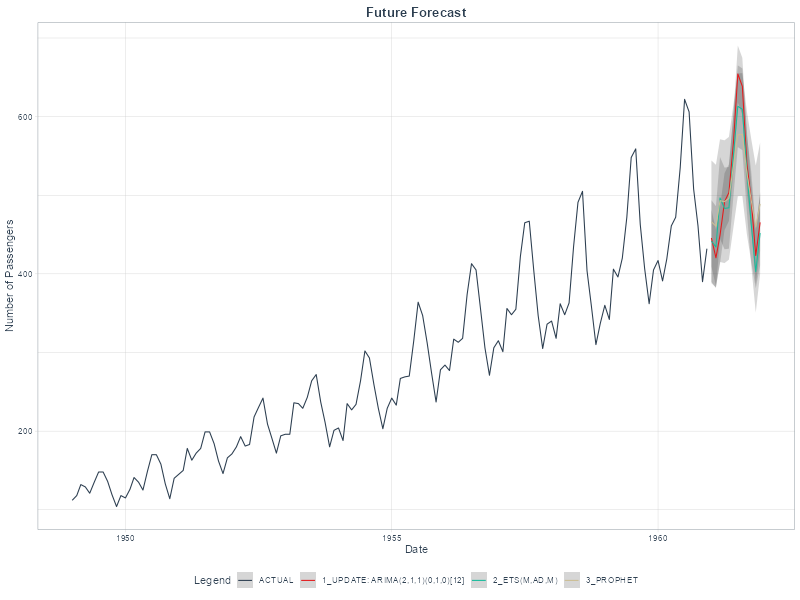

In [76]:
forecast_future %>%
  plot_modeltime_forecast(.title = "Future Forecast",
                          .x_lab = "Date",
                          .y_lab = "Number of Passengers",
                          .interactive = F)+
  theme(plot.title = element_text(hjust = 0.5, face = "bold"))

In [77]:
forecast_future %>%
  select(.model_desc, .index, .value, .conf_lo, .conf_hi) 

# Forecast Results
  Conf Method: conformal_default | Conf Interval: 0.95 | Conf By ID: FALSE (GLOBAL CONFIDENCE)
# A tibble: 180 × 5
   .model_desc .index     .value .conf_lo .conf_hi
   <chr>       <date>      <dbl>    <dbl>    <dbl>
 1 ACTUAL      1949-01-01    112       NA       NA
 2 ACTUAL      1949-02-01    118       NA       NA
 3 ACTUAL      1949-03-01    132       NA       NA
 4 ACTUAL      1949-04-01    129       NA       NA
 5 ACTUAL      1949-05-01    121       NA       NA
 6 ACTUAL      1949-06-01    135       NA       NA
 7 ACTUAL      1949-07-01    148       NA       NA
 8 ACTUAL      1949-08-01    148       NA       NA
 9 ACTUAL      1949-09-01    136       NA       NA
10 ACTUAL      1949-10-01    119       NA       NA
# ℹ 170 more rows
# ℹ Use `print(n = ...)` to see more rows

Use the below code to View the entire data (including predicted values)

In [78]:
forecast_future %>%
  select(.model_desc, .index, .value, .conf_lo, .conf_hi) |> View()